/data.nst/pspitzner/information_timescales/paper_plots/code/analysis_utils.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array([label.split(";") for label in data["label"].values])
/data.nst/pspitzner/information_timescales/paper_plots/code/analysis_utils.py:256: RuntimeWarning: divide by zero encountered in log10
  data.insert(11, "log_tau_R", np.log10(tau_Rs))


0 data points dropped by filter (0.00% of data) for measure R_tot
R_tot natural movie median:  0.08072 spontaneous activity median:  0.064


/data.nst/pspitzner/information_timescales/paper_plots/code/analysis_utils.py:3105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dummy, ignore_index=True)
/data.nst/pspitzner/information_timescales/paper_plots/code/analysis_utils.py:3105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dummy, ignore_index=True)


plotting 800 points for cat stimulus
p_wilcoxon=5.256915604905426e-172


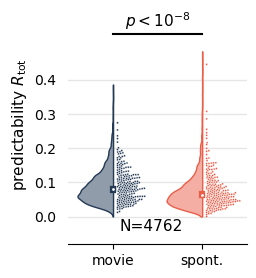

In [1]:
%reload_ext autoreload
%autoreload 2

import argparse
import logging
logging.getLogger("matplotlib.font_manager").disabled = True

defined_measures = ["tau_C", "tau_R", "R_tot"]
# parser = argparse.ArgumentParser()
# parser.add_argument("measure", type=str, help=f"one of {defined_measures}")
# args = parser.parse_args()
# if not args.measure in defined_measures:
#     parser.print_help()
#     exit()

args = argparse.Namespace()
# args.measure = "tau_C"
# args.measure = "tau_R"
args.measure = "R_tot"

print_difference = False
print_pvalue_base_ten = True


from sys import exit
from os.path import realpath, dirname, isfile, isdir
import os
import yaml

try:
    SCRIPT_DIR = dirname(realpath(__file__))
except:
    SCRIPT_DIR = "/data.nst/pspitzner/information_timescales/paper_plots/code"
with open("{}/dirs.yaml".format(SCRIPT_DIR), "r") as dir_settings_file:
    dir_settings = yaml.load(dir_settings_file, Loader=yaml.BaseLoader)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

import analysis_utils as utl

from matplotlib.legend_handler import HandlerTuple
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.colors

### settings

analysis = "allen_fc"

center = "median"  # measure of central tendency
T_measure = "log_tau_R"
R_measure = "R_tot"
C_measure = (  # also refers to two timescale fit, depending on mre_stats_file_name
    "log_mre_tau"
)

stimuli = ["natural_movie_one_more_repeats", "spontaneous"]
T0 = 0.03  # 30 ms
selected_structures = "cortex"

plot_stars = False  # plot stars or p-values for tests

# setup analysis
plot_settings = utl.get_default_plot_settings()
plt.rcParams.update(plot_settings["rcparams"])
plot_settings["panel_width"] = 0.35 * plot_settings["textwidth"]
plot_settings["panel_height"] = 2.9
plot_settings["rcparams"]["figure.figsize"] = [
    plot_settings["panel_width"],
    plot_settings["panel_height"],
]
plot_settings["panel_size"] = [
    plot_settings["panel_width"],
    plot_settings["panel_height"],
]
plot_settings["imgdir"] = "/data.nst/pspitzner/information_timescales/paper_plots/img/"

stats_dir = dir_settings["stats_dir"]

csv_file_name = "{}/{}_statistics_T0_30.csv".format(stats_dir, analysis)
# mre_stats_file_name = "{}/{}_mre_statistics_T0_30_Tmax_2500.csv".format(stats_dir, analysis)
mre_stats_file_name = "{}/{}_mre_statistics_T0_30_Tmax_10000_two_timescales.csv".format(
    stats_dir, analysis
)

structures = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
structures_map = utl.get_structures_map()
structures_cortex = [
    structure
    for structure in structures
    if structures_map[structure]["parent_structure"] == "cortex"
]
stimuli_map = utl.get_stimuli_map(bo_analysis=(analysis == "allen_bo"))

### import data

data = utl.get_analysis_data(
    csv_file_name, analysis, mre_stats_file_name=mre_stats_file_name
)

# make sure data as expected
if selected_structures == "cortex+thalamus":
    _structures = structures
elif selected_structures == "cortex":
    _structures = structures_cortex
else:
    print("unknown structures selected")
    exit()

data = data[utl.df_filter(data, structures=_structures, stimuli=stimuli, T0=T0, tmin=T0)]

try:
    num_neurons = utl.get_expected_number_of_neurons(
        analysis, selected_structures, stimuli
    )
    assert np.isclose(len(data), num_neurons, atol=100)
except:
    print(f"number of neurons is {len(data)}, expected {num_neurons}")
    exit()


# plot
fig0, ax = plt.subplots(figsize=plot_settings["panel_size"])
fig0.subplots_adjust(right=0.98, left=0.1, bottom=0.1)

if args.measure == "tau_C":
    lims = [-2.4, 1.9]
    # ax.set_title("intrinsic timescale")
    measure = C_measure
elif args.measure == "tau_R":
    lims = [-3.1, 0.8]
    # ax.set_title("information timescale")
    measure = T_measure
elif args.measure == "R_tot":
    lims = [-0.06, 0.6]
    # ax.set_title("predictability")
    measure = R_measure

selection = utl.get_data_filter(data, measure)
data = data[selection]

movie_data, sp_data, diff_data, valid_units = utl.get_data_for_stimulus_conditions(
    data, stimuli, measure
)

if "log" in measure:
    print(
        args.measure,
        "natural movie median: ",
        10 ** utl.get_center(movie_data, center),
        "spontaneous activity median: ",
        10 ** utl.get_center(sp_data, center),
    )
else:
    print(
        args.measure,
        "natural movie median: ",
        utl.get_center(movie_data, center),
        "spontaneous activity median: ",
        utl.get_center(sp_data, center),
    )

utl.fancy_violins(
    data.loc[data["unit"].isin(valid_units), :],
    "stimulus",
    measure,
    ax=ax,
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=None,
    palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    violin_kwargs = dict(
        scale="width",
    ),
    swarm_kwargs = dict(
        size=1.4,
    )
)


def y_pos(k):
    return lims[0] + k * (lims[1] - lims[0])


if "log" in measure:
    d = 10 ** utl.get_center(sp_data, center) - 10 ** utl.get_center(movie_data, center)
    med_diff = d
    med_diff_rel = d / 10 ** utl.get_center(movie_data, center) * 100
else:
    d = utl.get_center(sp_data, center) - utl.get_center(movie_data, center)
    med_diff = d
    med_diff_rel = d / utl.get_center(movie_data, center) * 100
# print(sign_rf, structure, measure, med_diff_rel)

if print_difference:
    ax.text(1.1, y_pos(0.95), "d = {:.1f}%".format(med_diff_rel), color="k")


if measure == T_measure:
    y = y_pos(0.08)
elif measure == C_measure:
    # y = y_pos(0.1)
    y = y_pos(0.08)
elif measure == R_measure:
    y = y_pos(0.08)
else:
    y = max([max(d) for d in (movie_data, sp_data)]) + -0.05 * (lims[1] - lims[0])

# for x, d in zip([0, 1], (movie_data, sp_data)):
ax.text(0.43, y, "N={}".format(len(movie_data)), ha="center", va="top", color="k")

# Does only make sense for unpaired samples
# MW_u, MW_u = st.mannwhitneyu(movie_data, sp_data, alternative='two-sided')
p_wilcoxon = st.wilcoxon(diff_data).pvalue


x1, x2 = 0, 1
w = 0.05 * (lims[1] - lims[0])

if measure == "log_tau_R":
    y = min(y_pos(0.8), max([max(d) for d in (movie_data, sp_data)]) + 1.5 * w)
elif measure == "log_mre_tau":
    y = min(y_pos(0.8), max([max(d) for d in (movie_data, sp_data)]) + 1.5 * w)
else:
    # y = max([max(d) for d in (movie_data, sp_data)]) + 1.5 * w
    y = min(y_pos(0.8), max([max(d) for d in (movie_data, sp_data)]) + 1.5 * w)

text = "p-values"
if plot_stars:
    if p_wilcoxon < 0.001:
        num_stars = 3
    elif p_wilcoxon < 0.01:
        num_stars = 2
    elif p_wilcoxon < 0.05:
        num_stars = 1
    else:
        num_stars = 0
    text = "*" * num_stars if num_stars > 0 else "n.s."
elif print_pvalue_base_ten:
    if p_wilcoxon >= 1e-8:
        text = "$p$ = {}".format(utl.format_base_ten(p_wilcoxon))
    else:
        text = "$p < 10^{-8}$"
else:
    if p_wilcoxon < 0.0005:
        # text = '$p < 10^{-3}$'
        text = "$p < 0.001$"
    else:
        text = "$p$ = {:.2f}\n".format(p_wilcoxon)

# ax.plot([x1, x1, x2, x2], [y, y+w, y+w, y], lw=1.5, c='k')
# ax.plot([x1, x2], [y + w, y + w], lw=1.5, c="k")
# ax.text((x1 + x2) / 2, text_y_pos, text, ha="center", va="top", color="k")
# in axis coordinates
ax.plot([0.25, 0.75], [0.9, 0.9], lw=1.5, c="k", transform=ax.transAxes)
ax.text(0.5, 0.91, text, ha="center", va="bottom", color="k", transform=ax.transAxes)
print(f"{p_wilcoxon=}")


if measure == T_measure:
    ax.set_yticks([-3.0, -2.0, -1.0, 0.0])
if measure == C_measure:
    # ax.set_yticks([-3.0, -2.0, -1.0, 0.0, 1.0])
    ax.set_yticks([-2.0, -1.0, 0.0, 1.0])
if measure == R_measure:
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])

utl.format_ax(ax, measure, "y", set_ticks=False, tight_layout=False)
ax.set_ylim(lims)
utl.make_plot_pretty(ax)
ax.set_xlabel("")
ax.set_xticklabels([stimuli_map[stimulus]["name"] for stimulus in stimuli])

ax.get_figure().savefig(
    f"/data.nst/pspitzner/information_timescales/paper_plots/img/allen_violins_{measure}.pdf",
    bbox_inches="tight",
    dpi=300,
)